In [ ]:
import os
import json
import pandas as pd


##################################################
# Load the CSV raw data
##################################################
sql_extracted_data = "../../data/pipeline2/sql/regex_classified/filtered_epd_data02_classified_all_05.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(sql_extracted_data)

##################################################
# Load the JSON benchmark data (100_matched_bench.json)
# and map each "epd_name" to "epd_category" to use
# as our "expected chunk" for that product.
##################################################
bench_path = "../../data/pipeline2/json/100_matched_bench_EN_aligned.json"
with open(bench_path, "r", encoding="utf-8") as f:
    bench_data = json.load(f)

bench_dict = {
    item["epd_name"]: item["epd_category"]
    for item in bench_data
}

##################################################
# Prerpocess the DataFrame
##################################################

df["Product Name"] = df["Product Name"].str.lower()

# Extract the list of epd_names from the bench_dict
epd_names = list(bench_dict.keys())

# Filter df for rows where the 'epd_name' is in the epd_names list
filtered_df = df[df['Product Name'].isin(epd_names)]

# Drop duplicate rows based on 'Product Name' (keeps the first occurrence by default)
# filtered_df = filtered_df.drop_duplicates(subset='Product Name')

In [ ]:
filtered_df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tiktoken
import numpy as np
import statistics

# List of columns to analyze; add more column names here as needed.
columns_to_analyze = ["Product Name", "LCA Method Details", "Technological Applicability", "Technology Description"]

# Initialize tokenizer for computing token counts.
enc = tiktoken.get_encoding("o200k_base")

def analyze_column_stats(column_name):
    print(f"Statistics for column: {column_name}\n")
    
    # Compute character counts: each string's length.
    char_counts = filtered_df[column_name].apply(len).tolist()
    
    # Compute token counts using tiktoken.
    token_counts = [len(enc.encode(text)) for text in filtered_df[column_name]]
    
    # Calculate basic statistical measures:
    # Mean: the average value.
    mean_chars = statistics.mean(char_counts) if char_counts else 0
    mean_tokens = statistics.mean(token_counts) if token_counts else 0

    # Median: the middle value in a sorted list.
    median_chars = np.median(char_counts) if char_counts else 0
    median_tokens = np.median(token_counts) if token_counts else 0

    # Standard deviation: a measure of the dispersion of the dataset.
    std_chars = np.std(char_counts, ddof=1) if len(char_counts) > 1 else 0
    std_tokens = np.std(token_counts, ddof=1) if len(token_counts) > 1 else 0

    # Percentiles: show the values below which a certain percentage of data falls.
    percentiles_chars = np.percentile(char_counts, [25, 50, 75, 90, 95]) if char_counts else [0] * 5
    percentiles_tokens = np.percentile(token_counts, [25, 50, 75, 90, 95]) if token_counts else [0] * 5

    # Interquartile Range (IQR): difference between the 75th and 25th percentiles, measuring variability.
    iqr_chars = percentiles_chars[2] - percentiles_chars[0]
    iqr_tokens = percentiles_tokens[2] - percentiles_tokens[0]

    # Print the computed statistics.
    # print(f"Mean character count: {mean_chars:.2f}")
    # print(f"Median character count: {median_chars:.2f}")
    # print(f"Standard deviation (chars): {std_chars:.2f}")
    # print(f"25th, 50th, 75th, 90th, 95th percentiles (chars): {percentiles_chars}")
    # print(f"IQR (chars): {iqr_chars:.2f}\n")

    print(f"Mean token count: {mean_tokens:.2f}")
    print(f"Median token count: {median_tokens:.2f}")
    print(f"Standard deviation (tokens): {std_tokens:.2f}")
    print(f"25th, 50th, 75th, 90th, 95th percentiles (tokens): {percentiles_tokens}")
    print(f"IQR (tokens): {iqr_tokens:.2f}\n")
    
    # Function to print histogram data in numeric format.
    def print_histogram_data(data, bins=20, title="Histogram Data"):
        counts, bin_edges = np.histogram(data, bins=bins)
        print(title)
        for i in range(len(counts)):
            lower = bin_edges[i]
            upper = bin_edges[i + 1]
            print(f"{lower:5.1f} - {upper:5.1f}: {counts[i]}")
    
    # print_histogram_data(char_counts, bins=20, title="Character Count Histogram Data")
    print_histogram_data(token_counts, bins=20, title="Token Count Histogram Data")
    print("\n" + "-"*50 + "\n")

    # # Plot histograms for visual inspection of the distributions.
    # plt.figure(figsize=(10, 5))
    # plt.hist(char_counts, bins=20, edgecolor="black")
    # plt.title(f"Character Count Distribution - {column_name}")
    # plt.xlabel("Character Count")
    # plt.ylabel("Frequency")
    # plt.show()

    # plt.figure(figsize=(10, 5))
    # plt.hist(token_counts, bins=20, edgecolor="black")
    # plt.title(f"Token Count Distribution - {column_name}")
    # plt.xlabel("Token Count")
    # plt.ylabel("Frequency")
    # plt.show()



# Loop through each column and apply the analysis.
for column in columns_to_analyze:
    analyze_column_stats(column)


In [ ]:
import pandas as pd
import tiktoken

# Assume filtered_df is your original DataFrame.
# Make copies to avoid SettingWithCopyWarning.
df_orig = filtered_df.copy()
df_trunc = filtered_df.copy()

# Define fixed token budgets for the three fixed columns.
# (The fixed budget for "Technology Description" will be replaced dynamically.)
max_token_per_column = {
    "Product Name": 40,
    "LCA Method Details": 25,
    "Technological Applicability": 125,
    "Technology Description": 300  # This value will serve as a placeholder.
}

# Initialize the tokenizer.
enc = tiktoken.get_encoding("o200k_base")

def truncate_text(text, max_tokens):
    """
    Truncates the given text to a maximum number of tokens.
    If the text is shorter than max_tokens, returns the text unchanged.
    """
    tokens = enc.encode(text)
    if len(tokens) <= max_tokens:
        return text
    truncated_tokens = tokens[:max_tokens]
    return enc.decode(truncated_tokens)

# ===== Process the original DataFrame (df_orig) =====
# Compute original token counts for each column.
for col in max_token_per_column.keys():
    df_orig[col] = df_orig[col].astype(str)
    df_orig[col + "_orig_token_count"] = df_orig[col].apply(lambda text: len(enc.encode(text)))
    
# Sum the original token counts per row.
orig_token_cols = [col + "_orig_token_count" for col in max_token_per_column.keys()]
df_orig["total_orig_token_count"] = df_orig[orig_token_cols].sum(axis=1)

# Prepare original_df: keep the original columns plus the total token count.
original_columns = list(filtered_df.columns) + ["total_orig_token_count"]
original_df = df_orig[original_columns].copy()

# ===== Process the truncated DataFrame (df_trunc) =====
# Define the columns that will use fixed token budgets.
other_columns = ["Product Name", "LCA Method Details", "Technological Applicability"]

# For the fixed columns, truncate using their fixed budgets.
for col in other_columns:
    df_trunc[col] = df_trunc[col].astype(str)
    truncated_col = col + "_truncated"
    token_count_col = col + "_truncated_token_count"
    
    df_trunc[truncated_col] = df_trunc[col].apply(lambda text: truncate_text(text, max_token_per_column[col]))
    df_trunc[token_count_col] = df_trunc[truncated_col].apply(lambda text: len(enc.encode(text)))
    
    # Print statistics for this column.
    orig_counts = df_orig[col + "_orig_token_count"]
    trunc_counts = df_trunc[token_count_col]
    print(f"Column: {col}")
    print(f"  Original token count - min: {orig_counts.min()}, max: {orig_counts.max()}, mean: {orig_counts.mean():.2f}")
    print(f"  Truncated token count - min: {trunc_counts.min()}, max: {trunc_counts.max()}, mean: {trunc_counts.mean():.2f}")
    print(f"  Token budget: {max_token_per_column[col]}")
    print("-" * 50)

# For "Technology Description", use dynamic token allocation.
df_trunc["Technology Description"] = df_trunc["Technology Description"].astype(str)
# First, compute the sum of the truncated token counts for the other columns.
df_trunc["others_truncated_sum"] = (
    df_trunc["Product Name_truncated_token_count"] +
    df_trunc["LCA Method Details_truncated_token_count"] +
    df_trunc["Technological Applicability_truncated_token_count"]
)
# Allowed tokens for Technology Description = 512 - sum of other truncated tokens.
df_trunc["TechDesc_allowed_tokens"] = 512 - df_trunc["others_truncated_sum"]
# Ensure the allowed token count is not negative.
df_trunc["TechDesc_allowed_tokens"] = df_trunc["TechDesc_allowed_tokens"].apply(lambda x: max(x, 0))

# Define a function to truncate "Technology Description" using the dynamic allowed tokens.
def dynamic_truncate(row):
    text = row["Technology Description"]
    allowed = row["TechDesc_allowed_tokens"]
    return truncate_text(text, allowed)

df_trunc["Technology Description_truncated"] = df_trunc.apply(dynamic_truncate, axis=1)
df_trunc["Technology Description_truncated_token_count"] = df_trunc["Technology Description_truncated"].apply(lambda text: len(enc.encode(text)))

# Print statistics for "Technology Description".
orig_counts = df_orig["Technology Description_orig_token_count"]
trunc_counts = df_trunc["Technology Description_truncated_token_count"]
print(f"Column: Technology Description")
print(f"  Original token count - min: {orig_counts.min()}, max: {orig_counts.max()}, mean: {orig_counts.mean():.2f}")
print(f"  Truncated token count - min: {trunc_counts.min()}, max: {trunc_counts.max()}, mean: {trunc_counts.mean():.2f}")
print("  Dynamic token budget: per row computed as 512 minus sum of other columns' truncated token counts")
print("-" * 50)

# Sum the truncated token counts for each row.
trunc_token_cols = [col + "_truncated_token_count" for col in other_columns] + ["Technology Description_truncated_token_count"]
df_trunc["total_truncated_token_count"] = df_trunc[trunc_token_cols].sum(axis=1)

# Prepare final_df: include only the truncated text columns (without individual token count columns) plus the summed token count.
truncated_text_cols = [col + "_truncated" for col in other_columns] + ["Technology Description_truncated"]
final_df = df_trunc[truncated_text_cols + ["total_truncated_token_count"]].copy()

# ===== Print outputs for verification =====
print("\nOriginal DF with total original token count:")
print(original_df.head())

print("\nFinal DF (truncated texts with summed token count):")
print(final_df.head())


In [ ]:
original_df

In [ ]:
final_df

# Embedding Models Evaluation

In [37]:
import os
import json
import pandas as pd
import datetime
from typing import List, Dict, Any
import torch
import gc
import re
from pydantic import PrivateAttr


import tiktoken

from sentence_transformers import SentenceTransformer

from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores.faiss import FAISS
from langchain.embeddings.base import Embeddings


##################################################
# Custom SentenceTransformer Embeddings
##################################################
class CustomSentenceTransformerEmbeddings(Embeddings):
    """
    Allows using a SentenceTransformer model within a LangChain-based FAISS store.
    Handles initialization of different models with specific arguments.
    """

    def __init__(self, embedding_model_name: str):
        self.embedding_model_name = embedding_model_name
        self.model = self._initialize_model()

    def _initialize_model(self) -> SentenceTransformer:
        """
        Initializes the SentenceTransformer model based on the embedding_model_name.
        """
        # Define initialization configurations for each model
        model_configs = {
            "jinaai/jina-embeddings-v3": {
                "trust_remote_code": True,
                "revision": "main",
                "device": "cuda",
                "model_kwargs": {"use_flash_attn": False},
            },
            "HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5": {
                "local_files_only": True,
                "device": "cuda",
                "model_kwargs": {"attn_implementation": "eager"},
            },
            "Alibaba-NLP/gte-large-en-v1.5": {
                "trust_remote_code": True,
                "revision": "main",
                "device": "cuda",
                "model_kwargs": {"attn_implementation": "eager"},
            },
        }

        config = model_configs.get(
            self.embedding_model_name,
            {"device": "cuda", "model_kwargs": {}},  # default fallback
        )

        try:
            model = SentenceTransformer(self.embedding_model_name, **config)
            print(f"Initialized SentenceTransformer model: {self.embedding_model_name}")
            return model
        except Exception as e:
            print(f"Error initializing model {self.embedding_model_name}: {e}")
            raise

    def embed_query(self, text: str) -> List[float]:
        return self.model.encode(text).tolist()

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        return self.model.encode(texts).tolist()

    def unload_model(self):
        """
        Remove the model from memory after processing to free up GPU resources.
        """
        if self.model:
            del self.model
            self.model = None
            torch.cuda.empty_cache()
            gc.collect()
            print(f"Unloaded embedding model: {self.embedding_model_name}")
        else:
            print("[DEBUG] Embedding model was already None or not set.")
    
################################
# Evaluation Helper Functions
################################
def strip_content_between_dashes(chunk):
    """
    Removes content between `---` markers, inclusive, if it exists in the chunk.
    """
    if "---" in chunk:
        return re.sub(r"---.*?---", "", chunk, flags=re.DOTALL).strip()
    return chunk

def evaluate_retrieval(retrieved_chunks, expected_chunks, comparison_length=100):
    """
    Strips content between `---` markers in the retrieved chunks, then compares
    them with the expected chunks based on the first `comparison_length` characters.

    This refactored version performs a more granular one-chunk-to-all-retrieved comparison:
    for each expected chunk, it checks whether that chunk (by its leading characters) appears
    among the retrieved chunks. The returned `correctly_retrieved` and `missed_chunks` are
    sets of the matching or missing chunk prefixes, respectively.

    Args:
        retrieved_chunks (List[str]): A list of text chunks retrieved from the vector store.
        expected_chunks (List[str]): A list of text chunks we expect to see in the retrieval.
        comparison_length (int, optional): The number of leading characters to compare. Defaults to 100.

    Returns:
        Tuple[Set[str], Set[str]]:
            - correctly_retrieved: A set of expected chunk prefixes that matched any retrieved chunk.
            - missed_chunks: A set of expected chunk prefixes that did not match any retrieved chunk.
    """
    # Convert both retrieved and expected chunks to lowercase, and strip out content between "---"
    processed_retrieved_chunks = [
        strip_content_between_dashes(chunk).lower() for chunk in retrieved_chunks
    ]
    processed_expected_chunks = [
        strip_content_between_dashes(chunk).lower() for chunk in expected_chunks
    ]

    # Build a set of retrieved prefixes for quick membership checks
    retrieved_prefixes = {
        chunk[:comparison_length].strip() for chunk in processed_retrieved_chunks
    }

    # print(retrieved_prefixes)
    # Go chunk-by-chunk for each expected prefix, checking if it's in retrieved_prefixes
    correctly_retrieved = set()
    missed_chunks = set()

    for chunk in processed_expected_chunks:
        prefix = chunk[:comparison_length].strip()
        if prefix in retrieved_prefixes:
            # print(prefix)
            # for chunk in retrieved_prefixes:
            #     print(f"\t{chunk}")
            correctly_retrieved.add(prefix)
        else:
            missed_chunks.add(prefix)

    # Print the original summary info exactly as before
    print(f"\nExact-Match Evaluation (First {comparison_length} characters):")
    print(
        f"  Correctly retrieved chunks: {len(correctly_retrieved)}/{len(expected_chunks)}"
    )
    for prefix in correctly_retrieved:
        print(f"    ✔ Retrieved Prefix: {prefix}")

    print(f"  Missed chunks: {len(missed_chunks)}/{len(expected_chunks)}")
    for prefix in missed_chunks:
        print(f"    ✘ Missed Prefix: {prefix}")

    return correctly_retrieved, missed_chunks


def evaluate_ranked_retrieval(docs_with_ranks, expected_chunks, comparison_length=100):
    """
    Rank-based check: for each expected chunk, see at which rank its prefix appears
    in the retrieved list, then compute Mean Rank and MRR.
    """
    processed_docs_with_ranks = [
        (rank, strip_content_between_dashes(doc.page_content))
        for rank, doc in docs_with_ranks
    ]
    processed_expected_chunks = [
        strip_content_between_dashes(chunk) for chunk in expected_chunks
    ]

    ranks = []
    for chunk in processed_expected_chunks:
        chunk_prefix = chunk[:comparison_length].strip()
        matched_positions = [
            rank
            for (rank, doc) in processed_docs_with_ranks
            if doc[:comparison_length].strip() == chunk_prefix
        ]
        if matched_positions:
            ranks.append(matched_positions[0])
        else:
            ranks.append(None)

    found_ranks = [r for r in ranks if r is not None]
    missed_count = sum(r is None for r in ranks)

    if found_ranks:
        if len(found_ranks) == 1:
            mean_rank = found_ranks[0]
            rank = int(mean_rank)
        else:
            mean_rank = sum(found_ranks) / len(found_ranks)
            rank = None
        mrr = sum((1.0 / r) for r in found_ranks) / len(found_ranks)
    else:
        mean_rank = None
        rank = None
        mrr = None

    print(f"\nRanked Evaluation (First {comparison_length} characters):")
    print(f"  Found: {len(found_ranks)}/{len(expected_chunks)}")
    print(f"  Missed: {missed_count}/{len(expected_chunks)}")
    if mean_rank is not None:
        print(f"  Mean Rank: {mean_rank:.2f}")
    else:
        print(f"  Mean Rank: N/A")
    if rank is not None:
        print(f"  Rank: {rank}")
    else:
        print(f"  Rank: N/A")
    if mrr is not None:
        print(f"  MRR: {mrr:.3f}")
    else:
        print(f"  MRR: N/A")

    return mean_rank, rank, mrr


def save_csv(evaluation_data, k_value, lambda_mult, output_csv_path):
    df_eval = pd.DataFrame(evaluation_data)
    df_eval["k_value"] = k_value
    df_eval["lambda_mult"] = lambda_mult

    columns_order = [
        "model",
        "row_index",
        "product_name",
        "k_value",
        "lambda_mult",
        "retrieved_docs",
        "found_exact",
        "missed_exact",
        "mean_rank",
        "rank",
        "mrr",
    ]
    df_eval = df_eval.reindex(columns=columns_order, fill_value="N/A")

    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    if not os.path.exists(output_csv_path):
        df_eval.to_csv(output_csv_path, index=False, mode="w", encoding="utf-8")
    else:
        df_eval.to_csv(
            output_csv_path, index=False, mode="a", header=False, encoding="utf-8"
        )


############################################################
# compare_rows: For each row in the CSV (first 100),
# build a query using Product Name + Classification +
# Technology Description. Then retrieve & evaluate.
############################################################
def compare_rows(
    df: pd.DataFrame,
    bench_dict: Dict[str, str],
    embedding_model_name: str,
    schema: str,
    k_value: int,
    output_csv_path: str,
    comparison_length: int = 100,
    fetch_k: int = 100,
    lambda_mult: float = 0.8,
):
    """
    For each row in the DataFrame, build a query that includes:
      - Product Name
      - Classification
      - Technology Description (summarized)
    Then retrieve documents using the vectorstore retriever and
    evaluate them against the expected chunk from bench_dict,
    keyed by the EPD Name.
    """
    evaluation_data = []

    for idx, row in df.iterrows():
        # Use for JSON
        # product_name = row["Product Name"]
        # classification = row["Classification Suggestion"]
        # classification = row["Classification Result"]
        # tech_description = row["Technology Description Summary"]
        # tech_description = row["Technology Description"]
        # comp_materials = row["Extracted Composition"]

        # Use for CSV
        product_uuid = row["UUID"]
        product_name = row["EPD Name"]
        # classification = row["Classification Result"]
        lca_method_details = row["LCA Method Details"]
        tech_description = row["Technology Description"]
        tech_applicability = row["Technological Applicability"]
        flow_prop_name = row["Flow Property Name"]
        flow_prop_mean_value = row["Flow Property Mean Value"]
        flow_prop_ref_unit = row["Flow Property Reference Unit"]
        tech_applicability = row["Technological Applicability"]
        flow_property = f"{flow_prop_mean_value} {flow_prop_ref_unit} ({flow_prop_name})"

        # Build the query from the entire row
        query_str = (
            # f"Product Name: {product_name}\n"
            # f"Classification: {classification}\n"
            # f"Technology Description: {tech_description}\n"
            # f"Composition Materials: {comp_materials}"
            f"Product: {product_name}\n"
            # f"Description: {tech_description}\n"
            # f"{tech_description}\n"
            # ""
        )

        # if lca_method_details:
        #     query_str += f"LCA Method Details: {lca_method_details}\n"
        if tech_applicability:
            query_str += f"Technological Applicability: {tech_applicability}\n"
        if tech_description:
            query_str += f"Technology Description: {tech_description}\n"
        # if flow_property:
        #     query_str += f"Flow Property: {flow_property}\n"
        # for i in range(1, 6):
        #     mat = row[f"Material Property {i}"]
        #     if mat:
        #         query_str += f"Material Property {i}: {mat}\n"
        # if classification != "Other":
        #     query_str += f"Classification: {classification}\n"

        query_length = len(query_str)
        print(f"Query Length: {query_length} characters")
        # Truncate tp 512 tokens or 1900 characters or these models crash
        if embedding_model_name in ["jeffh/intfloat-multilingual-e5-large-instruct:f32", "granite-embedding:278m", "bge-large:latest"]:
        # # Initialize the tokenizer.
        # enc = tiktoken.get_encoding("o200k_base")

        # # Encode the query string to get its token count.
        # tokens = enc.encode(query_str)
        # print(f"Original token count: {len(tokens)}")

        # # If the token count exceeds 512, truncate the tokens.
        # if len(tokens) > 512:
        #     truncated_tokens = tokens[:300]
        #     query_str = enc.decode(truncated_tokens)
        #     print(f"Truncated token count: {len(truncated_tokens)}")

        # Truncate to 1900 characters limiting tokens is not reliable
            query_str = query_str[:1900]     

        # The expected chunk for ranking/evaluation:
        # If the product name doesn't exist in bench_dict,
        # we treat the expected chunk as empty or skip evaluation.
        expected_chunk = bench_dict.get(product_uuid, "")

        # Skip if no known expected chunk
        if not expected_chunk:
            print(f"[Warning] No expected benchmark info for product '{product_name}'")
            continue

        print(f"\n[Model: {embedding_model_name}]")
        print(f"[Row Index: {idx}]")
        print(f"Query:\n{query_str}")  # Print query for inspection
        # print(f"Expected Chunk Name:\n{expected_chunk}")
        # print(f"Product Name:{product_name}\n")

        # Retrieve using MMR-based approach
        retriever = vectorstore.as_retriever(
            search_type="mmr",
            search_kwargs={
                # "filter": {"schema_type": schema}, # There is no filter
                "k": k_value,
                "fetch_k": fetch_k,
                "lambda_mult": lambda_mult,
            },
        )

        # retrieved_docs = retriever.invoke(query_str[:1900]) # Truncate query
        retrieved_docs = retriever.invoke(query_str)
        print(f"Number of retrieved documents: {len(retrieved_docs)}")

        retrieved_chunks = [doc.page_content for doc in retrieved_docs]

        # Evaluate retrieval
        found_exact, missed_chunks = evaluate_retrieval(
            retrieved_chunks, [expected_chunk], comparison_length=comparison_length
        )

        # Evaluate ranking
        docs_with_ranks = list(enumerate(retrieved_docs, start=1))
        mean_rank, rank, mrr = evaluate_ranked_retrieval(
            docs_with_ranks, [expected_chunk], comparison_length=comparison_length
        )

        # Show top 5 for inspection (optional)
        top_docs = retrieved_chunks[:5]
        processed_top_docs = [strip_content_between_dashes(doc) for doc in top_docs]
        print(f"\n[Top 5 Retrieved Docs]")
        for i, doc_text in enumerate(processed_top_docs, start=1):
            print(f"  {i}. {doc_text}")

        # Collect the evaluation results
        evaluation_data.append(
            {
                "model": embedding_model_name,
                "row_index": idx,
                "product_name": product_name,
                "retrieved_docs": len(retrieved_docs),
                "found_exact": len(found_exact),
                "missed_exact": len(missed_chunks),
                "mean_rank": mean_rank,
                "rank": rank,
                "mrr": mrr,
            }
        )

    # Check how many were evaluated
    print(f"From {len(df)} EPDs, {len(evaluation_data)} were evaluated.")

    # Save results for all rows
    save_csv(evaluation_data, k_value, lambda_mult, output_csv_path)


##################################################
# Load the JSON summaries
##################################################
# summaries_path = "../../data/pipeline2/json/100_tech_sum_one_paragraph_regex.json"
# summaries_path = "../../data/pipeline2/json/100_technology_summaries.json"
# with open(summaries_path, "r", encoding="utf-8") as f:
#     tech_summaries = json.load(f)

# Create a DataFrame from the JSON data
# df_summaries = pd.DataFrame(tech_summaries)
# print(df_summaries)

##################################################
# Load the CSV raw data
##################################################
sample_epds = "../data/sample_100_repres_EPDs02.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(sample_epds, keep_default_na=False)

##################################################
# Load the JSON benchmark data (100_matched_bench.json)
# and map each "epd_name" to "epd_category" to use
# as our "expected chunk" for that product.
##################################################
bench_path = "../data/bench_100_EPDs.json"
with open(bench_path, "r", encoding="utf-8") as f:
    bench_data = json.load(f)

bench_dict = {item["epd_uuid"]: item["epd_category"] for item in bench_data}

#########
# Usage
#########
# k_values = [10, 20, 30, 40, 50] # Used for testing
k_values = [50]
# k_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80]
# k_values = [40, 50, 60, 70, 80] 

# lambda_mults = [0.7, 0.8, 0.9, 1.0] # Used for testing
lambda_mults = [1.0]

# Paths for the FAISS vectorstores (one for each model)
embeddings_name = "faiss_index_COS_EN"
embeddings_name_512 = "faiss_index_COS_EN"
vectorstore_paths = {
    # "bge-m3:latest": f"../../embeddings/pipeline2/bge-m3/{embeddings_name}",
    "snowflake-arctic-embed2:latest": f"../../embeddings/pipeline2/snowflake-arctic-embed2/{embeddings_name}",
    # "jina/jina-embeddings-v2-base-de:latest": f"../../embeddings/pipeline2/jina_jina-embeddings-v2-base-de/{embeddings_name}",
    # "paraphrase-multilingual:latest": f"../../embeddings/pipeline2/paraphrase-multilingual/{embeddings_name}",
    # "jeffh/intfloat-multilingual-e5-large-instruct:f32": f"../../embeddings/pipeline2/jeffh_intfloat-multilingual-e5-large-instruct/{embeddings_name_512}", # Fails if input exceeds context length
    # "granite-embedding:278m": f"../../embeddings/pipeline2/granite-embedding-278m/{embeddings_name_512}", # Fails if input exceeds context length
    # "bge-large:latest": f"../../embeddings/pipeline2/bge-large/{embeddings_name_512}",  # Fails if input exceeds context length
    # "mxbai-embed-large:latest": f"../../embeddings/pipeline2/mxbai-embed-large/{embeddings_name_512}",
    "jinaai/jina-embeddings-v3": f"../../embeddings/pipeline2/jinaai_jina-embeddings-v3/{embeddings_name}",
    # "HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5": f"../../embeddings/pipeline2/HIT-TMG_KaLM-embedding-multilingual-mini-instruct-v1.5/{embeddings_name}",
    # "Alibaba-NLP/gte-large-en-v1.5": f"../../embeddings/pipeline2/Alibaba-NLP_gte-large-en-v1.5/{embeddings_name_512}",
}

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
output_csv_path = f"../../data/pipeline2/embed_eval/embed_eval_res_{timestamp}.csv"

# We'll evaluate row-by-row for each embedding model
schema_type = "epd_bench_schema"  # a placeholder schema type for filtering
for embedding_model_name, faiss_path in vectorstore_paths.items():
    print(f"\n=== Processing Embedding Model: {embedding_model_name} ===")

    # Choose embeddings class
    if embedding_model_name in [
        "jinaai/jina-embeddings-v3",
        "HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5",
        "Alibaba-NLP/gte-large-en-v1.5",
    ]:
        embeddings = CustomSentenceTransformerEmbeddings(embedding_model_name)
    else:
        embeddings = OllamaEmbeddings(model=embedding_model_name)
        print(f"Initialized Ollama embedding model: {embedding_model_name}")

    # Load vectorstore
    vectorstore = FAISS.load_local(
        faiss_path,
        embeddings=embeddings,
        allow_dangerous_deserialization=True,
    )

    for lm in lambda_mults:
        print(f"\n--- Evaluating with lambda_mult = {lm} ---")
        for kv in k_values:
            print(f"\n--- Evaluating with k_value = {kv} ---")
            compare_rows(
                df=df,
                bench_dict=bench_dict,
                embedding_model_name=embedding_model_name,
                schema=schema_type,
                k_value=kv,
                output_csv_path=output_csv_path,
                comparison_length=100,
                fetch_k=100,
                lambda_mult=lm,
            )

    # Unload the model to free up GPU memory
    if isinstance(embeddings, CustomSentenceTransformerEmbeddings):
        embeddings.unload_model()

print("\n>>> All embedding models have been processed and unloaded.")
print(f"\n>>> Completed. See results in {output_csv_path}.")


=== Processing Embedding Model: snowflake-arctic-embed2:latest ===
Initialized Ollama embedding model: snowflake-arctic-embed2:latest

--- Evaluating with lambda_mult = 1.0 ---

--- Evaluating with k_value = 50 ---
Query Length: 57 characters

[Model: snowflake-arctic-embed2:latest]
[Row Index: 0]
Query:
Product: S-P-00782 Gyproc Steel Profiles and Accessories

Number of retrieved documents: 50

Exact-Match Evaluation (First 100 characters):
  Correctly retrieved chunks: 1/1
    ✔ Retrieved Prefix: metals > steel and iron > structural steel profile
  Missed chunks: 0/1

Ranked Evaluation (First 100 characters):
  Found: 1/1
  Missed: 0/1
  Mean Rank: 1.00
  Rank: 1
  MRR: 1.000

[Top 5 Retrieved Docs]
  1. Metals > Steel and iron > Structural steel profile
  2. Metals > Stainless steel > Stainless steel profiles
  3. Metals > Aluminium > Aluminium profiles
  4. Plastics > Profiles > Rigid plastic profiles
  5. Metals > Copper > Copper profiles
Query Length: 887 characters

[Model: sno

## Evaluation Visualizations Embedding Models


In [38]:
CSV = "../../data/pipeline2/embed_eval/embed_eval_res_20250430_150906.csv"

Loaded 200 rows from ../../data/pipeline2/embed_eval/embed_eval_res_20250430_150906.csv


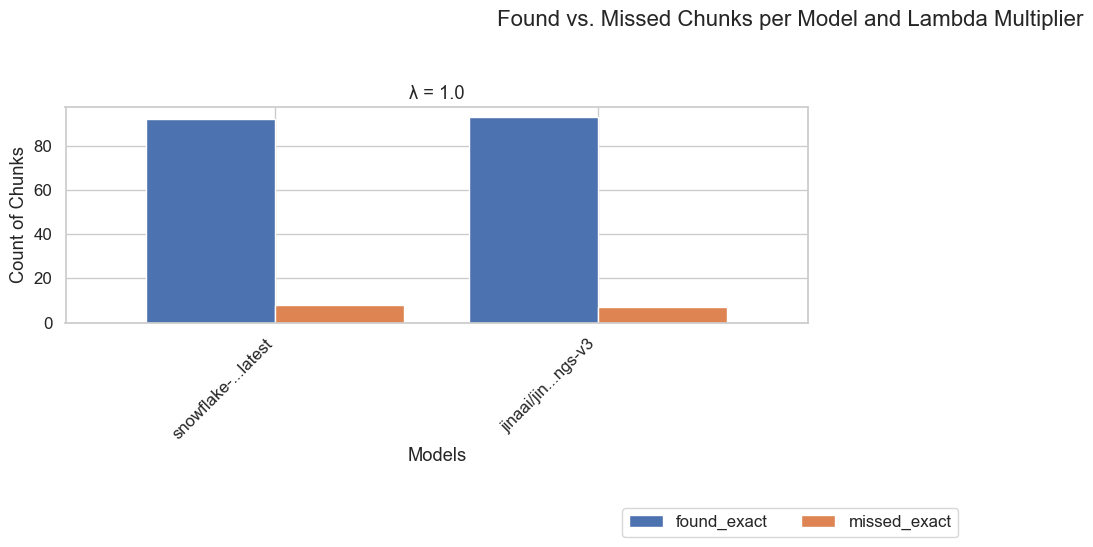

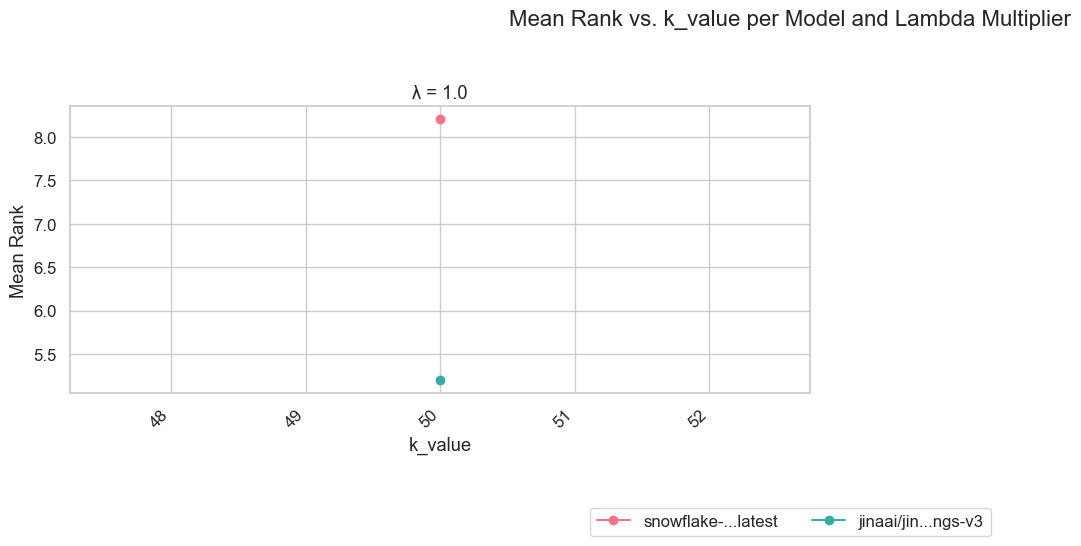

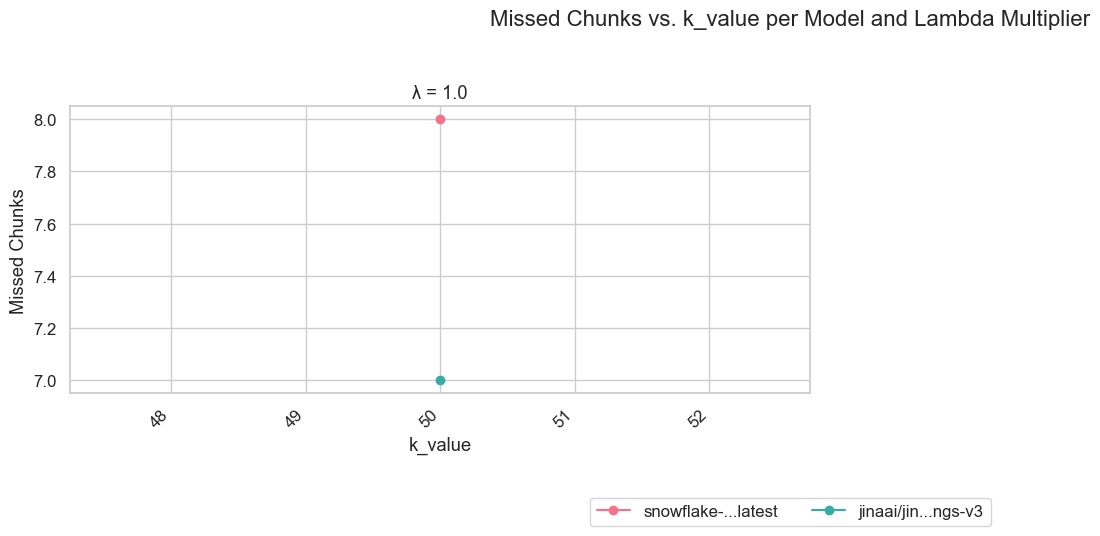


=== Aggregated Data from Plots ===

--- Found Exact vs. Missed Exact per Model and Lambda Multiplier ---

Lambda Multiplier: 1.0
                     found_exact  missed_exact
snowflake-...latest  92           8           
jinaai/jin...ngs-v3  93           7           

--- Mean Rank per k_value for Each Model and Lambda Multiplier ---

Lambda Multiplier: 1.0
   k_value model                            mean_rank
0  50       snowflake-arctic-embed2:latest  8.206522 
1  50            jinaai/jina-embeddings-v3  5.193548 

--- Missed Chunks per k_value for Each Model and Lambda Multiplier ---

Lambda Multiplier: 1.0
   k_value model                            missed_exact
0  50       snowflake-arctic-embed2:latest  8           
1  50            jinaai/jina-embeddings-v3  7           

====== BEST PERFORMANCE PER MODEL ======
Model                           Lambda  k_value  Misses Mean Rank
     jinaai/jina-embeddings-v3 1.0     50       7       5.19     
snowflake-arctic-embed2:latest 1.0

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
import os


def abbreviate_model_name(name):
    """
    Abbreviates the model name to show only the first 5 and last 5 characters.

    Parameters:
        name (str): The original model name.

    Returns:
        str: The abbreviated model name.
    """
    if len(name) <= 10:
        return name
    return f"{name[:10]}...{name[-6:]}"


def load_and_prepare_data(csv_file_path):
    """
    Loads the CSV data, performs basic cleanup, converts specified columns to numeric,
    and organizes the 'model' and 'lambda_mult' columns to preserve their order of appearance.

    Parameters:
        csv_file_path (str): The file path to the CSV file.

    Returns:
        df (pd.DataFrame): The cleaned and prepared DataFrame.
        model_order (list): List of models in the order they appear in the CSV.
        lambda_order (list): List of lambda_mult values in sorted order.
    """
    # 1) Load Data
    df = pd.read_csv(csv_file_path)

    # A. Basic Cleanup & Info
    print(f"Loaded {len(df)} rows from {csv_file_path}")
    # Uncomment below lines if you wish to see the first few rows
    # print("\n--- First 5 Rows of the DataFrame ---")
    # print(df.head())

    # B. Convert columns to numeric (MRR, mean_rank, etc.) if needed
    numeric_cols = [
        "k_value",
        "lambda_mult",
        "retrieved_docs",
        "found_exact",
        "missed_exact",
        "mean_rank",
        "mrr",
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # C. Visual Setup
    sns.set_theme(style="whitegrid", font_scale=1.1)

    # D. Organize 'model' Column Order
    # Extract unique models in the order they appear
    model_order = df["model"].drop_duplicates().tolist()

    # Set 'model' as a categorical variable with the specified order
    df["model"] = pd.Categorical(df["model"], categories=model_order, ordered=True)

    # E. Organize 'lambda_mult' Column Order (sorted)
    lambda_order = sorted(df["lambda_mult"].dropna().unique().tolist())
    df["lambda_mult"] = pd.Categorical(
        df["lambda_mult"], categories=lambda_order, ordered=True
    )

    return df, model_order, lambda_order


def plot_found_vs_missed(df, model_order, lambda_order):
    """
    Creates a series of bar charts comparing 'found_exact' vs. 'missed_exact' for each model segmented by 'lambda_mult'.
    Each lambda_mult value is plotted in its own subplot with abbreviated model names.
    A single consolidated legend is positioned below all subplots.

    Parameters:
        df (pd.DataFrame): The prepared DataFrame.
        model_order (list): List of models in the desired order.
        lambda_order (list): List of lambda_mult values in sorted order.

    Returns:
        agg_dict (dict): Dictionary containing aggregated DataFrames for each lambda_mult
    """
    num_lambdas = len(lambda_order)
    cols = 2  # Define number of columns in subplot grid
    rows = (num_lambdas + 1) // cols  # Calculate number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 5), sharey=True)
    axes = axes.flatten()  # Flatten in case of multiple rows

    agg_dict = {}  # To store aggregated data for each lambda_mult

    for idx, lambda_val in enumerate(lambda_order):
        ax = axes[idx]
        subset = df[df["lambda_mult"] == lambda_val]
        agg = (
            subset.groupby("model", observed=True)[["found_exact", "missed_exact"]]
            .sum()
            .reindex(model_order)
        )

        # Abbreviate model names
        abbreviated_models = [abbreviate_model_name(name) for name in agg.index]
        agg.index = abbreviated_models

        # Plotting
        agg.plot(kind="bar", ax=ax, width=0.8, legend=False)
        ax.set_title(f"λ = {lambda_val}")
        ax.set_xlabel("Models")
        ax.set_ylabel("Count of Chunks")
        ax.tick_params(axis="x", rotation=45)
        plt.setp(
            ax.get_xticklabels(), ha="right"
        )  # Set horizontal alignment separately

        agg_dict[lambda_val] = agg  # Store aggregated data

    # Remove any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    # Create a single legend for all subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 0))

    fig.suptitle("Found vs. Missed Chunks per Model and Lambda Multiplier", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return agg_dict


def plot_mean_rank_vs_kvalue(df, model_order, lambda_order):
    """
    Generates a series of line plots showing 'mean_rank' versus 'k_value' for each model segmented by 'lambda_mult'.
    Each lambda_mult value is plotted in its own subplot with a single legend positioned below all subplots.

    Parameters:
        df (pd.DataFrame): The prepared DataFrame.
        model_order (list): List of models in the desired order.
        lambda_order (list): List of lambda_mult values in sorted order.

    Returns:
        agg_dict (dict): Dictionary containing aggregated DataFrames for each lambda_mult.
    """
    num_lambdas = len(lambda_order)
    cols = 2  # Define number of columns in subplot grid
    rows = (num_lambdas + 1) // cols  # Calculate number of rows needed

    fig, axes = plt.subplots(
        rows, cols, figsize=(16, rows * 5), sharex=True, sharey=True
    )
    axes = axes.flatten()  # Flatten in case of multiple rows

    palette = sns.color_palette("husl", n_colors=len(model_order))

    agg_dict = {}  # To store aggregated data for each lambda_mult

    for idx, lambda_val in enumerate(lambda_order):
        ax = axes[idx]
        subset = df[df["lambda_mult"] == lambda_val]
        agg = (
            subset.groupby(["k_value", "model"], observed=True)["mean_rank"]
            .mean()
            .reset_index()
        )

        for i, model in enumerate(model_order):
            model_data = agg[agg["model"] == model]
            ax.plot(
                model_data["k_value"],
                model_data["mean_rank"],
                marker="o",
                label=abbreviate_model_name(model),
                color=palette[i % len(palette)],
            )

        ax.set_title(f"λ = {lambda_val}")
        ax.set_xlabel("k_value")
        ax.set_ylabel("Mean Rank")
        ax.tick_params(axis="x", rotation=45)
        plt.setp(
            ax.get_xticklabels(), ha="right"
        )  # Set horizontal alignment separately

        agg_dict[lambda_val] = agg  # Store aggregated data

    # Remove any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    # Create a single legend for all subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 0))

    fig.suptitle("Mean Rank vs. k_value per Model and Lambda Multiplier", fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

    return agg_dict


def plot_missed_chunks_vs_kvalue(df, model_order, lambda_order):
    """
    Produces a series of line plots illustrating 'missed_exact' versus 'k_value' for each model segmented by 'lambda_mult'.
    Each lambda_mult value is plotted in its own subplot with a single legend positioned below all subplots.

    Parameters:
        df (pd.DataFrame): The prepared DataFrame.
        model_order (list): List of models in the desired order.
        lambda_order (list): List of lambda_mult values in sorted order.

    Returns:
        agg_dict (dict): Dictionary containing aggregated DataFrames for each lambda_mult.
    """
    num_lambdas = len(lambda_order)
    cols = 2  # Define number of columns in subplot grid
    rows = (num_lambdas + 1) // cols  # Calculate number of rows needed

    fig, axes = plt.subplots(
        rows, cols, figsize=(16, rows * 5), sharex=True, sharey=True
    )
    axes = axes.flatten()  # Flatten in case of multiple rows

    palette = sns.color_palette("husl", n_colors=len(model_order))

    agg_dict = {}  # To store aggregated data for each lambda_mult

    for idx, lambda_val in enumerate(lambda_order):
        ax = axes[idx]
        subset = df[df["lambda_mult"] == lambda_val]
        agg = (
            subset.groupby(["k_value", "model"], observed=True)["missed_exact"]
            .sum()
            .reset_index()
        )

        for i, model in enumerate(model_order):
            model_data = agg[agg["model"] == model]
            ax.plot(
                model_data["k_value"],
                model_data["missed_exact"],
                marker="o",
                label=abbreviate_model_name(model),
                color=palette[i % len(palette)],
            )

        ax.set_title(f"λ = {lambda_val}")
        ax.set_xlabel("k_value")
        ax.set_ylabel("Missed Chunks")
        ax.tick_params(axis="x", rotation=45)
        plt.setp(
            ax.get_xticklabels(), ha="right"
        )  # Set horizontal alignment separately

        agg_dict[lambda_val] = agg  # Store aggregated data

    # Remove any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    # Create a single legend for all subplots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 0.02))

    fig.suptitle(
        "Missed Chunks vs. k_value per Model and Lambda Multiplier", fontsize=16
    )
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

    return agg_dict


def interpret_results(df, model_order, lambda_order):
    """
    Determines the best model based on the following criteria for each lambda_mult and returns the lambda_mult
    where the overall best model is found:
    1. Prefer models with zero total missed chunks (summed across all attributes).
       - Among these, choose the one with the lowest k_value.
       - If tied, choose the one with the lowest mean_rank.
    2. If no model has zero misses for a lambda_mult, choose the model with the lowest number of misses.
       - Among these, choose the one with the lowest k_value.
       - If tied, choose the one with the lowest mean_rank.

    Prints:
        Models sorted by k_value and then by mean_rank within each lambda_mult.
        DataFrame table of each model's best performance, sorted by lowest misses and then by lowest mean rank.

    Parameters:
        df (pd.DataFrame): The prepared DataFrame.
        model_order (list): List of models in the desired order.
        lambda_order (list): List of lambda_mult values in sorted order.

    Returns:
        best_lambda_mult (float): The lambda_mult corresponding to the overall best model.
    """
    # Build summary table
    agg = (
        df.groupby(["model", "lambda_mult", "k_value"], observed=True)
        .agg(
            total_missed_exact=pd.NamedAgg(column="missed_exact", aggfunc="sum"),
            average_mean_rank=pd.NamedAgg(column="mean_rank", aggfunc="mean"),
        )
        .reset_index()
    )

    results = {}
    for model in model_order:
        model_rows = agg[agg["model"] == model]
        if model_rows.empty:
            continue
        model_rows = model_rows.copy()
        # Sort key: lower misses, then lower mean rank, then lower k_value
        model_rows["sort_key"] = model_rows.apply(
            lambda row: (
                row["total_missed_exact"],
                row["average_mean_rank"],
                row["k_value"],
            ),
            axis=1,
        )
        best = model_rows.sort_values("sort_key").iloc[0]
        criteria = "Zero Misses" if best["total_missed_exact"] == 0 else "Lowest Misses"
        results[model] = {
            "lambda_mult": best["lambda_mult"],
            "k_value": best["k_value"],
            "misses": best["total_missed_exact"],
            "mean_rank": best["average_mean_rank"],
            "criteria": criteria,
        }

    rows = []
    for model in model_order:
        if model in results:
            r = results[model]
            rows.append(
                {
                    "Model": model,
                    "Lambda": r["lambda_mult"],
                    "k_value": r["k_value"],
                    "Misses": r["misses"],
                    "Mean Rank": r["mean_rank"],
                }
            )
        else:
            rows.append(
                {
                    "Model": model,
                    "Lambda": "N/A",
                    "k_value": "N/A",
                    "Misses": float("inf"),
                    "Mean Rank": float("inf"),
                }
            )

    summary_df = pd.DataFrame(rows)
    summary_df["Misses"] = pd.to_numeric(summary_df["Misses"], errors="coerce")
    summary_df["Mean Rank"] = pd.to_numeric(summary_df["Mean Rank"], errors="coerce")
    summary_df = summary_df.sort_values(
        by=["Misses", "Mean Rank"], ascending=[True, True]
    )
    summary_df["Mean Rank"] = summary_df["Mean Rank"].apply(
        lambda x: f"{x:.2f}" if pd.notnull(x) else "N/A"
    )

    # Set column header justification to left
    pd.set_option('display.colheader_justify', 'left')
    print("\n====== BEST PERFORMANCE PER MODEL ======")
    print(summary_df.to_string(index=False))

    
    markdown_df = summary_df.copy()

    # Calculate new column 'new_metric' as (100 - Misses) / 100
    markdown_df['top_k_accuracy'] = (100 - markdown_df['Misses']) / 100
    # Sort the DataFrame by 'top_k_accuracy'
    markdown_df = markdown_df.sort_values(by=["top_k_accuracy"], ascending=False)
    # Reset the index and drop the old one
    markdown_df = markdown_df.reset_index(drop=True)
    # Add an 'id' column starting at 1 and incrementing by 1 for each row.
    markdown_df.insert(0, 'Id', range(1, len(markdown_df) + 1))
    # Define a dictionary mapping for user-friendly column names
    rename_mapping = {
        "Id": "Nr.",
        "Lambda": "Lambda Multiplier",
        "Model": "Embedding Model",
        "k_value": "k Value",
        "Misses": "Category Not Found",
        "Mean Rank": "Mean Rank",
        "top_k_accuracy": "Top-k Accuracy",
    }
    markdown_df.rename(columns=rename_mapping, inplace=True)

    # Save summary as markdown
    markdown_str = tabulate(markdown_df, headers="keys", tablefmt="pipe", showindex=False)
    md_dir = os.path.join("..", "..", "data", "pipeline2", "md")
    os.makedirs(md_dir, exist_ok=True)
    csv_timestamp = CSV.split("/")[-1].replace(".csv", "")
    md_path = os.path.join(md_dir, f"summary_table_{csv_timestamp}.md")
    with open(md_path, "w", encoding="utf-8") as f:
        f.write(markdown_str)
    print(f"\nMarkdown summary saved to: {md_path}")

    csv_path = os.path.join(md_dir, f"summary_table_{csv_timestamp}.csv")     
    markdown_df.to_csv(csv_path, index=False)
    print(f"\nCSV summary saved to: {csv_path}")

    # Determine overall best model per lambda
    best_overall_criteria = None
    best_overall_list = []

    for lambda_val in lambda_order:
        print(f"\n===== Lambda Multiplier: {lambda_val} =====")
        subset = df[df["lambda_mult"] == lambda_val]
        group_agg = (
            subset.groupby(["model", "k_value"], observed=True)
            .agg(
                total_missed_exact=pd.NamedAgg(column="missed_exact", aggfunc="sum"),
                average_mean_rank=pd.NamedAgg(column="mean_rank", aggfunc="mean"),
            )
            .reset_index()
        )

        sorted_group = group_agg.sort_values(
            by=["total_missed_exact", "k_value", "average_mean_rank"],
            ascending=[True, True, True],
        )

        best_model_row = sorted_group.iloc[0]
        criteria = (
            "Zero Misses"
            if best_model_row["total_missed_exact"] == 0
            else "Lowest Misses"
        )
        best_model = best_model_row["model"]
        best_k = best_model_row["k_value"]
        best_misses = best_model_row["total_missed_exact"]
        best_mean_rank = best_model_row["average_mean_rank"]

        print("\n------ SUMMARY PER LAMBDA ------")
        if criteria == "Zero Misses":
            print(
                f"The best model for lambda {lambda_val} is '{best_model}' with "
                f"k_value={best_k} and mean_rank={best_mean_rank:.2f} (Zero Misses)."
            )
        else:
            print(
                f"No model had zero misses. Best for lambda {lambda_val} is '{best_model}' with "
                f"{int(best_misses)} misses, k_value={best_k}, mean_rank={best_mean_rank:.2f}."
            )

        # Now compare with the overall best
        if not best_overall_list:
            # This is the first best found; store it
            best_overall_criteria = criteria
            best_overall_list.append(
                {
                    "model": best_model,
                    "lambda_mult": lambda_val,
                    "k_value": best_k,
                    "misses": best_misses,
                    "mean_rank": best_mean_rank,
                    "criteria": criteria,
                }
            )
        else:
            # Compare with current best
            current_best = best_overall_list[0]  # All in list share same metrics
            # If new candidate has Zero Misses and old was Lowest Misses
            if criteria == "Zero Misses" and best_overall_criteria != "Zero Misses":
                best_overall_list.clear()
                best_overall_criteria = criteria
                best_overall_list.append(
                    {
                        "model": best_model,
                        "lambda_mult": lambda_val,
                        "k_value": best_k,
                        "misses": best_misses,
                        "mean_rank": best_mean_rank,
                        "criteria": criteria,
                    }
                )
            elif criteria == best_overall_criteria:
                # Both are "Zero Misses" or both "Lowest Misses"
                # Compare total misses, k_value, mean_rank
                if best_misses < current_best["misses"]:
                    best_overall_list.clear()
                    best_overall_list.append(
                        {
                            "model": best_model,
                            "lambda_mult": lambda_val,
                            "k_value": best_k,
                            "misses": best_misses,
                            "mean_rank": best_mean_rank,
                            "criteria": criteria,
                        }
                    )
                elif best_misses == current_best["misses"]:
                    if best_k < current_best["k_value"]:
                        best_overall_list.clear()
                        best_overall_list.append(
                            {
                                "model": best_model,
                                "lambda_mult": lambda_val,
                                "k_value": best_k,
                                "misses": best_misses,
                                "mean_rank": best_mean_rank,
                                "criteria": criteria,
                            }
                        )
                    elif best_k == current_best["k_value"]:
                        if best_mean_rank < current_best["mean_rank"]:
                            # strictly better mean rank
                            best_overall_list.clear()
                            best_overall_list.append(
                                {
                                    "model": best_model,
                                    "lambda_mult": lambda_val,
                                    "k_value": best_k,
                                    "misses": best_misses,
                                    "mean_rank": best_mean_rank,
                                    "criteria": criteria,
                                }
                            )
                        elif abs(best_mean_rank - current_best["mean_rank"]) < 1e-9:
                            # Same misses, same k, same mean rank => It's a tie
                            best_overall_list.append(
                                {
                                    "model": best_model,
                                    "lambda_mult": lambda_val,
                                    "k_value": best_k,
                                    "misses": best_misses,
                                    "mean_rank": best_mean_rank,
                                    "criteria": criteria,
                                }
                            )

            # If new candidate is "Lowest Misses" but current best is "Zero Misses", do nothing
            # because Zero Misses is always better.
    print("\n====== FINAL OVERALL BEST MODEL(S) ======")
    # All entries in best_overall_list share the same performance, but may differ in lambda
    # or even be different models with identical performance.
    # Print them all:
    if best_overall_list:
        for i, item in enumerate(best_overall_list, start=1):
            if item["criteria"] == "Zero Misses":
                print(
                    f"({i}) `{item['model']}` with `k_value = {item['k_value']}`, `mean_rank = {item['mean_rank']:.2f}`, "
                    f"(Zero Misses), `lambda_mult = {item['lambda_mult']}`"
                )
            else:
                print(
                    f"({i}) `{item['model']}` with `{int(item['misses'])} misses`, `k_value = {item['k_value']}`, "
                    f"`mean_rank = {item['mean_rank']:.2f}`, `lambda_mult = {item['lambda_mult']}`"
                )
        return best_overall_list[0]["lambda_mult"]
    else:
        print("No best model was found.")
        return None


def visualize_embedding_results(csv_file_path):
    """
    Orchestrates the loading of data and creation of visualizations for embedding model comparisons,
    now segmented by 'lambda_mult'. Aggregated data from all plots are printed at the end.

    Parameters:
        csv_file_path (str): The file path to the CSV file.
    """
    # Load and prepare data
    df, model_order, lambda_order = load_and_prepare_data(csv_file_path)

    # Create Visualizations and collect aggregated data
    agg_found_vs_missed = plot_found_vs_missed(df, model_order, lambda_order)
    agg_mean_rank = plot_mean_rank_vs_kvalue(df, model_order, lambda_order)
    agg_missed_chunks = plot_missed_chunks_vs_kvalue(df, model_order, lambda_order)

    # Print all aggregated data
    print("\n=== Aggregated Data from Plots ===")

    # Found vs. Missed
    print("\n--- Found Exact vs. Missed Exact per Model and Lambda Multiplier ---")
    for lambda_val, agg in agg_found_vs_missed.items():
        print(f"\nLambda Multiplier: {lambda_val}")
        print(agg)

    # Mean Rank
    print("\n--- Mean Rank per k_value for Each Model and Lambda Multiplier ---")
    for lambda_val, agg in agg_mean_rank.items():
        print(f"\nLambda Multiplier: {lambda_val}")
        print(agg)

    # Missed Chunks
    print("\n--- Missed Chunks per k_value for Each Model and Lambda Multiplier ---")
    for lambda_val, agg in agg_missed_chunks.items():
        print(f"\nLambda Multiplier: {lambda_val}")
        print(agg)

    # Interpret Results and determine best lambda
    best_lambda_mult = interpret_results(df, model_order, lambda_order)
    return best_lambda_mult


plot_csv_file = CSV

best_lambda_mult = visualize_embedding_results(plot_csv_file)
print("BEST LAMBDA MULT FROM FIRST CODE:", best_lambda_mult)

In [40]:
best_lambda_mult = 1.0

Loaded 200 rows from ../../data/pipeline2/embed_eval/embed_eval_res_20250430_150906.csv

Using best_lambda_mult = 1.0
Remaining rows after filtering: 200


C:\Users\Georgi\AppData\Local\Temp\ipykernel_24108\3490262280.py:110: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=0.2)


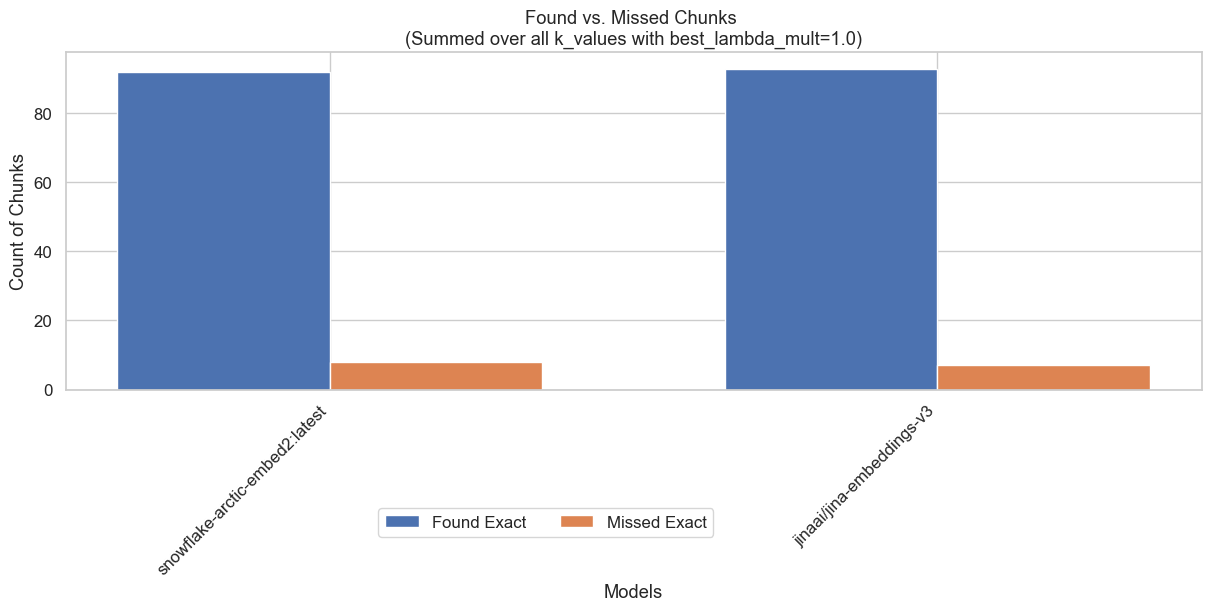


--- Found Exact vs. Missed Exact per Model (Filtered) ---
  model                            found_exact  missed_exact
0  snowflake-arctic-embed2:latest  92           8           
1       jinaai/jina-embeddings-v3  93           7           


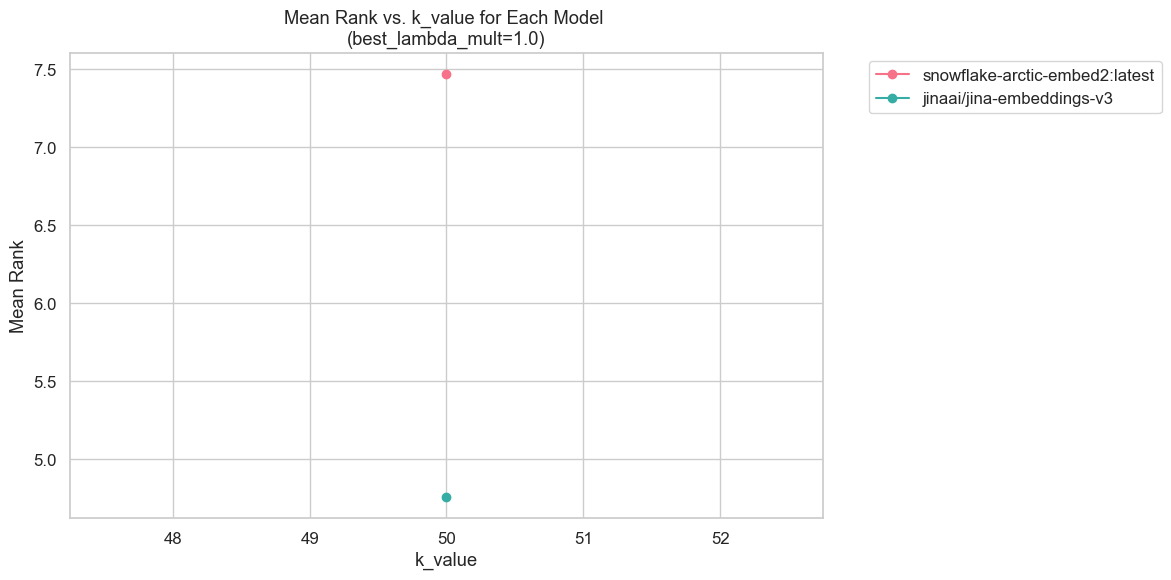


--- Mean Rank per k_value for Each Model (Filtered) ---

Model: snowflake-arctic-embed2:latest
 k_value  mean_rank
50       7.47      

Model: jinaai/jina-embeddings-v3
 k_value  mean_rank
50       4.76      


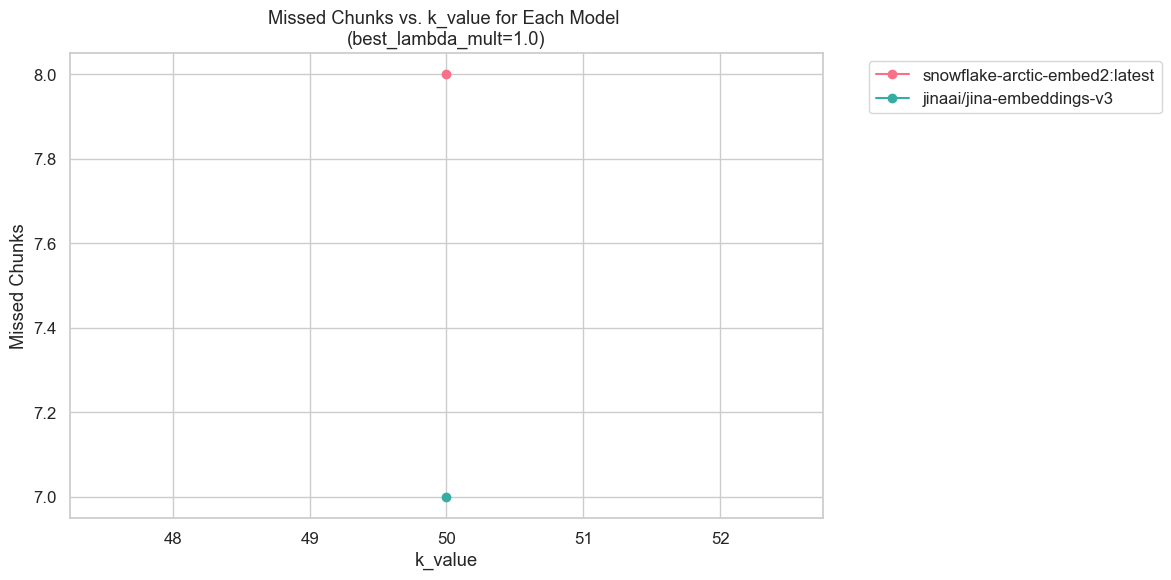


--- Missed Chunks per k_value for Each Model (Filtered) ---

Model: snowflake-arctic-embed2:latest
 k_value  missed_exact
50       8            

Model: jinaai/jina-embeddings-v3
 k_value  missed_exact
50       7            


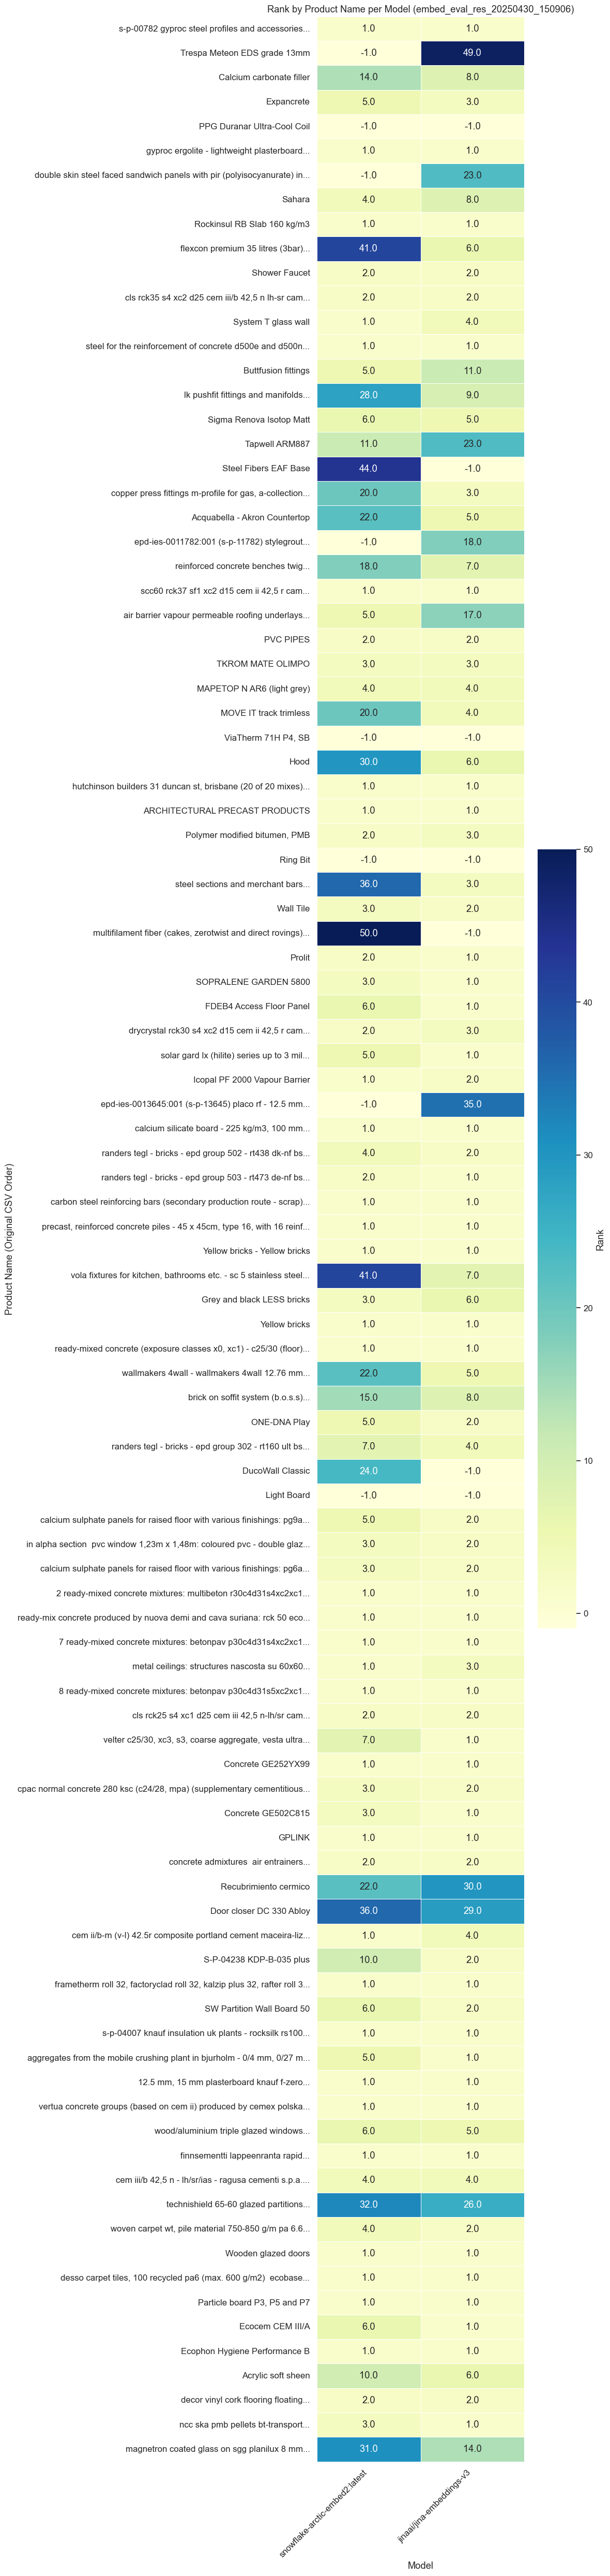


====== AGGREGATED RESULTS (Filtered) ======
  model                            k_value  missed_exact  mean_rank
0  snowflake-arctic-embed2:latest  50       8             7.47     
1       jinaai/jina-embeddings-v3  50       7             4.76     

====== MINIMUM k_value WITH ZERO MISSES (Filtered) ======
No model achieved zero total misses under this lambda.

====== SUMMARY (Filtered) ======
No zero-miss model under this lambda. Best is `jinaai/jina-embeddings-v3` with `7 misses`, `k_value = 50`, `mean_rank = 4.76`.


In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def abbreviate_product_name(name):
    """
    Abbreviates the product name.

    Parameters:
        name (str): The original product name.

    Returns:
        str: The abbreviated product name.
    """
    if len(name) <= 30:
        return name
    return f"{name.lower()[:70]}..."


def load_and_prepare_data(csv_file_path):
    """
    Loads the CSV data, performs basic cleanup, converts specified columns to numeric,
    fills missing numeric values with -1, and organizes 'model' and 'lambda_mult'
    to preserve their order of appearance.
    """
    df = pd.read_csv(csv_file_path)
    print(f"Loaded {len(df)} rows from {csv_file_path}")

    # Fixed numeric_cols list by adding the missing comma after "rank"
    numeric_cols = [
        "k_value",
        "retrieved_docs",
        "found_exact",
        "missed_exact",
        "mean_rank",
        "rank",
        "mrr",
        "lambda_mult",
    ]
    
    for col in numeric_cols:
        if col in df.columns:
            # Convert the column to numeric, coercing errors to NaN
            df[col] = pd.to_numeric(df[col], errors="coerce")
            # Fill NaN values with -1
            df[col] = df[col].fillna(-1)

    sns.set_theme(style="whitegrid", font_scale=1.1)

    # Organize 'model' by appearance order
    model_order = df["model"].drop_duplicates().tolist()
    df["model"] = pd.Categorical(df["model"], categories=model_order, ordered=True)

    # Organize 'lambda_mult' by sorted order if it exists
    if "lambda_mult" in df.columns:
        lambda_order = sorted(df["lambda_mult"].dropna().unique().tolist())
        df["lambda_mult"] = pd.Categorical(
            df["lambda_mult"], categories=lambda_order, ordered=True
        )
    else:
        lambda_order = []

    return df, model_order, lambda_order

def plot_found_vs_missed(df, model_order, best_lambda_mult):
    """
    Side-by-side bar chart for 'found_exact' vs. 'missed_exact' for each model (filtered by best lambda).
    """
    fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
    subset = df.groupby("model", as_index=False, observed=True)[
        ["found_exact", "missed_exact"]
    ].sum()

    # Re-sort models after filtering
    subset["model"] = pd.Categorical(
        subset["model"], categories=model_order, ordered=True
    )
    subset = subset.dropna(subset=["model"]).sort_values("model")

    X = range(len(subset))
    width = 0.35
    ax.bar(
        [x - width / 2 for x in X],
        subset["found_exact"],
        width=width,
        label="Found Exact",
    )
    ax.bar(
        [x + width / 2 for x in X],
        subset["missed_exact"],
        width=width,
        label="Missed Exact",
    )
    ax.set_xticks(X)
    ax.set_xticklabels(subset["model"], rotation=45, ha="right")
    ax.set_title(
        f"Found vs. Missed Chunks \n(Summed over all k_values with best_lambda_mult={best_lambda_mult})"
    )
    ax.set_xlabel("Models")
    ax.set_ylabel("Count of Chunks")
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="lower center",
        ncol=2,
        frameon=True,
        bbox_to_anchor=(0.45, 0.1),
    )
    fig.subplots_adjust(bottom=0.2)
    plt.show()

    print("\n--- Found Exact vs. Missed Exact per Model (Filtered) ---")
    print(subset)


def plot_mean_rank_vs_kvalue(df, model_order, best_lambda_mult):
    """
    Line plot showing 'mean_rank' vs. 'k_value' for each model (filtered by best lambda).
    """
    plt.figure(figsize=(12, 6))
    mean_rank_summary = {}

    palette = sns.color_palette("husl", n_colors=len(model_order))

    for i, model_name in enumerate(model_order):
        model_data = df[df["model"] == model_name]
        meanranks = model_data.groupby("k_value")["mean_rank"].mean().reset_index()
        mean_rank_summary[model_name] = meanranks
        plt.plot(
            meanranks["k_value"],
            meanranks["mean_rank"],
            marker="o",
            label=model_name,
            color=palette[i % len(palette)],
        )

    plt.title(
        f"Mean Rank vs. k_value for Each Model \n(best_lambda_mult={best_lambda_mult})"
    )
    plt.xlabel("k_value")
    plt.ylabel("Mean Rank")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    print("\n--- Mean Rank per k_value for Each Model (Filtered) ---")
    for model, summary in mean_rank_summary.items():
        print(f"\nModel: {model}")
        print(summary.to_string(index=False))


def plot_missed_chunks_vs_kvalue(df, model_order, best_lambda_mult):
    """
    Line plot illustrating 'missed_exact' vs. 'k_value' for each model (filtered by best lambda).
    """
    plt.figure(figsize=(12, 6))
    missed_summary = {}

    palette = sns.color_palette("husl", n_colors=len(model_order))

    for i, model_name in enumerate(model_order):
        model_data = df[df["model"] == model_name]
        if model_data.empty:
            continue
        missed_per_k = model_data.groupby("k_value")["missed_exact"].sum().reset_index()
        missed_summary[model_name] = missed_per_k
        plt.plot(
            missed_per_k["k_value"],
            missed_per_k["missed_exact"],
            marker="o",
            label=model_name,
            color=palette[i % len(palette)],
        )

    plt.title(
        f"Missed Chunks vs. k_value for Each Model \n(best_lambda_mult={best_lambda_mult})"
    )
    plt.xlabel("k_value")
    plt.ylabel("Missed Chunks")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    print("\n--- Missed Chunks per k_value for Each Model (Filtered) ---")
    for model, summary in missed_summary.items():
        print(f"\nModel: {model}")
        print(summary.to_string(index=False))


def plot_heatmap_rank(df, model_order, best_lambda_mult, csv_file_path):
    """
    Plots a heatmap of rank values with Product Name on the Y-axis,
    ensuring the products appear in the original CSV order and that 
    missing rank values are replaced with -1. Also, appends part of the
    CSV file name to the plot title.
    """
    # Extract the base CSV filename without extension
    csv_base = os.path.basename(csv_file_path)
    csv_name = os.path.splitext(csv_base)[0]
    
    # Preserve original CSV order by creating a unique order index
    df["Product Order"] = df["product_name"].factorize()[0]
    df["Product Name (Short)"] = df["product_name"].apply(abbreviate_product_name)

    # Aggregate rank values to ensure unique (Product Order, Product Name, Model) combinations
    rank_df = (
        df.groupby(["Product Order", "Product Name (Short)", "model"], observed=True)["rank"]
          .mean()  # Take the mean rank across different k-values
          .reset_index()
          .rename(columns={
              "model": "Model",
              "Product Name (Short)": "Product Name",
              "rank": "Rank"
          })
    )

    # Ensure the DataFrame is sorted by the original CSV order
    rank_df = rank_df.sort_values("Product Order")

    # Pivot using both "Product Order" and "Product Name" to maintain order
    pivot_data = rank_df.pivot_table(
        index=["Product Order", "Product Name"],
        columns="Model",
        values="Rank",
        aggfunc="mean",
        observed=True,
    )

    # Sort the pivot table by the "Product Order" level
    pivot_data = pivot_data.sort_index(level="Product Order")

    # Drop the "Product Order" level so that only the product names appear on the y-axis
    pivot_data.index = pivot_data.index.droplevel("Product Order")
    
    # Plotting the heatmap with the CSV part appended to the title
    plt.figure(figsize=(12, 50))  # Adjust height for better visualization
    sns.heatmap(
        pivot_data,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        linewidths=0.5,
        cbar_kws={"label": "Rank"}
    )
    plt.title(f"Rank by Product Name per Model ({csv_name})")
    plt.xlabel("Model")
    plt.ylabel("Product Name (Original CSV Order)")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0, ha="right")
    plt.tight_layout()
    plt.show()

    # Convert pivot_data to string
    # heatmap_rank_df_string = pivot_data.to_string()

    return pivot_data


def interpret_results(df):
    """
    Same logic as before, but operates on the already filtered DataFrame (by best_lambda).
    Determines the best model under that single lambda context.
    """
    group_agg = (
        df.groupby(["model", "k_value"], observed=True)
        .agg(
            missed_exact=pd.NamedAgg(column="missed_exact", aggfunc="sum"),
            mean_rank=pd.NamedAgg(column="mean_rank", aggfunc="mean"),
        )
        .reset_index()
    )

    print("\n====== AGGREGATED RESULTS (Filtered) ======")
    print(group_agg)

    sorted_group = group_agg.sort_values(
        by=["missed_exact", "k_value", "mean_rank"],
        ascending=[True, True, True],
    )

    best_model_row = sorted_group.iloc[0]
    if best_model_row["missed_exact"] == 0:
        criteria = "Zero Misses"
    else:
        criteria = "Lowest Misses"

    best_model = best_model_row["model"]
    best_k = best_model_row["k_value"]
    best_misses = best_model_row["missed_exact"]
    best_mean_rank = best_model_row["mean_rank"]

    print("\n====== MINIMUM k_value WITH ZERO MISSES (Filtered) ======")
    zero_miss_df = group_agg[group_agg["missed_exact"] == 0]
    if not zero_miss_df.empty:
        models_zero_miss = (
            zero_miss_df.groupby("model", observed=True)
            .agg(min_k_value=pd.NamedAgg(column="k_value", aggfunc="min"))
            .reset_index()
        )
        merged_zero_miss = pd.merge(
            models_zero_miss,
            zero_miss_df,
            left_on=["model", "min_k_value"],
            right_on=["model", "k_value"],
        )
        merged_zero_miss_sorted = merged_zero_miss.sort_values(
            by=["min_k_value", "mean_rank"]
        )
        for _, row in merged_zero_miss_sorted.iterrows():
            print(
                f"{row['model']}: k_value = {row['min_k_value']}, mean_rank = {row['mean_rank']:.2f}"
            )
    else:
        print("No model achieved zero total misses under this lambda.")

    print("\n====== SUMMARY (Filtered) ======")
    if criteria == "Zero Misses":
        print(
            f"Best model (filtered) is `{best_model}` with "
            f"`k_value = {best_k}` and `mean_rank = {best_mean_rank:.2f}` (Zero Misses)."
        )
    else:
        print(
            f"No zero-miss model under this lambda. Best is `{best_model}` with "
            f"`{int(best_misses)} misses`, `k_value = {best_k}`, `mean_rank = {best_mean_rank:.2f}`."
        )

    return group_agg


def visualize_embedding_results(csv_file_path, best_lambda_mult):
    """
    Orchestrates loading data, filtering on the best lambda, and creating visualizations.
    """
    df, model_order, lambda_order = load_and_prepare_data(csv_file_path)

    # Filter to the best lambda identified from the first code
    df = df[df["lambda_mult"] == best_lambda_mult]
    df = df.dropna(subset=["model"])
    # Update model order after filtering
    new_model_order = df["model"].drop_duplicates().tolist()
    df["model"] = pd.Categorical(df["model"], categories=new_model_order, ordered=True)

    print(f"\nUsing best_lambda_mult = {best_lambda_mult}")
    print(f"Remaining rows after filtering: {len(df)}")

    plot_found_vs_missed(df, new_model_order, best_lambda_mult)
    plot_mean_rank_vs_kvalue(df, new_model_order, best_lambda_mult)
    plot_missed_chunks_vs_kvalue(df, new_model_order, best_lambda_mult)
    heatmap_rank_df_string = plot_heatmap_rank(df, new_model_order, best_lambda_mult, csv_file_path)
    group_agg = interpret_results(df)

    return group_agg, heatmap_rank_df_string


########
# Usage
########
best_lambda_mult = best_lambda_mult
group_agg, heatmap_rank_df_string = visualize_embedding_results(plot_csv_file, best_lambda_mult)

In [26]:
heatmap_rank_df_string

Model,snowflake-arctic-embed2:latest,jinaai/jina-embeddings-v3
Product Name,,
s-p-00782 gyproc steel profiles and accessories...,7.0,40.0
Trespa Meteon EDS grade 13mm,7.0,40.0
Calcium carbonate filler,-1.0,-1.0
Expancrete,-1.0,-1.0
PPG Duranar Ultra-Cool Coil,-1.0,-1.0
...,...,...
Ecophon Hygiene Performance B,-1.0,-1.0
Acrylic soft sheen,-1.0,-1.0
decor vinyl cork flooring floating...,19.0,-1.0


In [54]:
df_filter_missed = heatmap_rank_df_string[heatmap_rank_df_string['jinaai/jina-embeddings-v3'] == -1]
selected_df = df_filter_missed[['jinaai/jina-embeddings-v3']]
selected_df

Model,jinaai/jina-embeddings-v3
Product Name,
PPG Duranar Ultra-Cool Coil,-1.0
Steel Fibers EAF Base,-1.0
"ViaTherm 71H P4, SB",-1.0
Ring Bit,-1.0
"multifilament fiber (cakes, zerotwist and direct rovings)...",-1.0
DucoWall Classic,-1.0
Light Board,-1.0


In [ ]:
# Print the heatmap data in text format
print("\nHeatmap Data (Text Format):\n")
print(visualize_embedding_results_txt)

In [ ]:
visualize_embedding_results_txt

In [49]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Calculate new column 'new_metric' as (100 - missed_exact) / 100
group_agg['top_k_accuracy'] = (100 - group_agg['missed_exact']) / 100

# Sort the DataFrame by 'top_k_accuracy'
sorted_df = group_agg.sort_values(by=["top_k_accuracy"], ascending=False)

# Reset the index and drop the old one
sorted_df = sorted_df.reset_index(drop=True)

# Add an 'id' column starting at 1 and incrementing by 1 for each row.
sorted_df.insert(0, 'Id', range(1, len(sorted_df) + 1))

display_df = sorted_df.copy()

# Define a dictionary mapping for user-friendly column names
rename_mapping = {
    "Id": "Nr.",
    "model": "Embedding Model",
    "k_value": "k Value",
    "missed_exact": "Category Not Found",
    "mean_rank": "Mean Rank",
    "top_k_accuracy": "Top-k Accuracy",
}

# Rename columns using the mapping dictionary
display_df.rename(columns=rename_mapping, inplace=True)

display_df

,Nr.,Embedding Model,k Value,Category Not Found,Mean Rank,Top-k Accuracy
0,1,jinaai/jina-embeddings-v3,50,7,5.44,0.93
1,2,snowflake-arctic-embed2:latest,50,8,8.35,0.92
2,3,bge-m3:latest,50,11,8.37,0.89
3,4,jeffh/intfloat-multilingual-e5-large-instruct:f32,50,13,5.51,0.87
4,5,HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5,50,16,6.03,0.84
5,6,mxbai-embed-large:latest,50,17,7.90,0.83
6,7,Alibaba-NLP/gte-large-en-v1.5,50,19,8.64,0.81
7,8,jina/jina-embeddings-v2-base-de:latest,50,20,7.82,0.80
8,9,bge-large:latest,50,21,8.89,0.79
9,10,granite-embedding:278m,50,22,5.80,0.78


In [50]:
# Print the sorted DataFrame in markdown format
print(display_df.to_markdown(index=False))

|   Nr. | Embedding Model                                        |   k Value |   Category Not Found |   Mean Rank |   Top-k Accuracy |
|------:|:-------------------------------------------------------|----------:|---------------------:|------------:|-----------------:|
|     1 | jinaai/jina-embeddings-v3                              |        50 |                    7 |        5.44 |             0.93 |
|     2 | snowflake-arctic-embed2:latest                         |        50 |                    8 |        8.35 |             0.92 |
|     3 | bge-m3:latest                                          |        50 |                   11 |        8.37 |             0.89 |
|     4 | jeffh/intfloat-multilingual-e5-large-instruct:f32      |        50 |                   13 |        5.51 |             0.87 |
|     5 | HIT-TMG/KaLM-embedding-multilingual-mini-instruct-v1.5 |        50 |                   16 |        6.03 |             0.84 |
|     6 | mxbai-embed-large:latest                     